In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import torch
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from src.dataset import load_qm9
from src.model import HybridEGNN
from src.utils import get_device

DEVICE = get_device()

# Инвариантность

Для исходной и преобразованной молекул предскажем $U_0$, при инвариантности предсказания будут идентичными.

Настройка вращения и трансляции

In [3]:
# Матрица поворота (90 градусов вокруг Z) и вектор сдвига
R = torch.tensor([[0., -1., 0.], [1., 0., 0.], [0., 0., 1.]])
t = torch.tensor([5.0, 5.0, 5.0])

transform = T.Compose([
    T.LinearTransformation(R), 
    lambda d: (setattr(d, 'pos', d.pos + t), d)[1]
])

Загрузка данных (берём 100-ю молекулу), настройка модели

In [4]:
dataset = load_qm9(root='../data', target_idx=7)

# Исходная молекула
data_orig = dataset[100].to(DEVICE)

# Преобразованная молекула
data_trans = transform(data_orig.clone())

model = HybridEGNN(128, 128, n_egnn_layers=4, tda_feature_dim=0).to(DEVICE)
model.load_state_dict(torch.load('../models/U0_Base_EGNN_seed42.pth', map_location=DEVICE, weights_only=True))
model.eval()

HybridEGNN(
  (embedding): Embedding(10, 128)
  (egnn_layers): ModuleList(
    (0-3): 4 x E(n)-GNN Layer for Graphs {'training': False, '_parameters': {}, '_buffers': {}, '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': {'aggr_module': SumAggregation(), 'dropout': Identity(), 'edge_mlp': Sequential(
      (0): Linear(in_features=257, out_features=514, bias=True)
      (1): Identity()
      (2): SiLU()
      (3): Linear(in_features=514, out_features=16, bias=True)
      (4): SiLU()
    ), 'coors_norm': Identity()

Предсказание $U_0$ для исходной и преобразованной молекул

In [5]:
with torch.no_grad():
    y_orig = model(data_orig.z, data_orig.pos, data_orig.batch, data_orig.edge_index)
    y_trans = model(data_trans.z, data_trans.pos, data_trans.batch, data_trans.edge_index)

In [6]:
print("Предсказания совпали:", torch.allclose(y_orig, y_trans))

Предсказания совпали: True


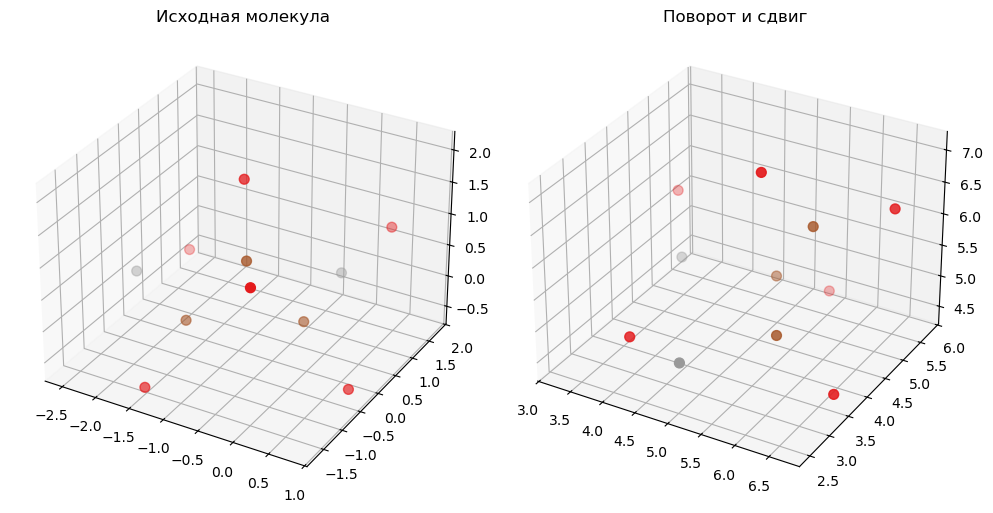

In [7]:
fig = plt.figure(figsize=(10, 5))
for i, (d, title) in enumerate([(data_orig, "Исходная молекула"), (data_trans, "Поворот и сдвиг")]):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    p = d.pos.cpu().numpy()
    ax.scatter(p[:,0], p[:,1], p[:,2], c=d.z.cpu(), s=50, cmap='Set1')
    ax.set_title(title)
plt.tight_layout()
plt.show()

# Эквивариантность

Для исходной и преобразованной молекулы сравним координаты атомов, а также повернём выходные координаты сами.

Функция получения "выходных" координат, преобразованных в ходе прямого обхода

In [8]:
def get_coords(model, molecule):
    with torch.no_grad():
        h = model.node_in_proj(model.embedding(molecule.z))
        coords = molecule.pos
        for layer in model.egnn_layers:
            combined = layer(torch.cat([coords, h], dim=-1), molecule.edge_index, batch=molecule.batch)
            coords, h = combined[:, :3], combined[:, 3:]
    return coords

Создание молекулы, повёрнутой на 90 градусов вокруг оси Z

In [9]:
data_rot = T.LinearTransformation(R)(data_orig.clone())

In [10]:
# "Выходные" координаты исходной молекулы
p_out_orig = get_coords(model, data_orig)
print("Выходные координаты исходной молекулы (1-й атом)\t\t", p_out_orig[0])

# "Выходные" координаты повёрнутой молекулы
p_out_from_rot = get_coords(model, data_rot)
print("Выходные координаты повёрнутой МОДЕЛЬЮ молекулы (1-й атом)\t", p_out_from_rot[0])

# Вручную повёрнутые координаты исходной молекулы
rotated_p_out_orig = p_out_orig @ R.T.to(DEVICE)
print("Выходные координаты повёрнутой ВРУЧНУЮ молекулы (1-й атом)\t", rotated_p_out_orig[0])

Выходные координаты исходной молекулы (1-й атом)		 tensor([-0.2980,  0.7361,  0.2047])
Выходные координаты повёрнутой МОДЕЛЬЮ молекулы (1-й атом)	 tensor([-0.7361, -0.2980,  0.2047])
Выходные координаты повёрнутой ВРУЧНУЮ молекулы (1-й атом)	 tensor([-0.7361, -0.2980,  0.2047])


In [11]:
print("Координаты атомов, повернутых моделью и вручную, совпали:", torch.allclose(rotated_p_out_orig, p_out_from_rot, atol=1e-5))

Координаты атомов, повернутых моделью и вручную, совпали: True


Визуализация "выходных" координат исходной и повёрнутой молекул 

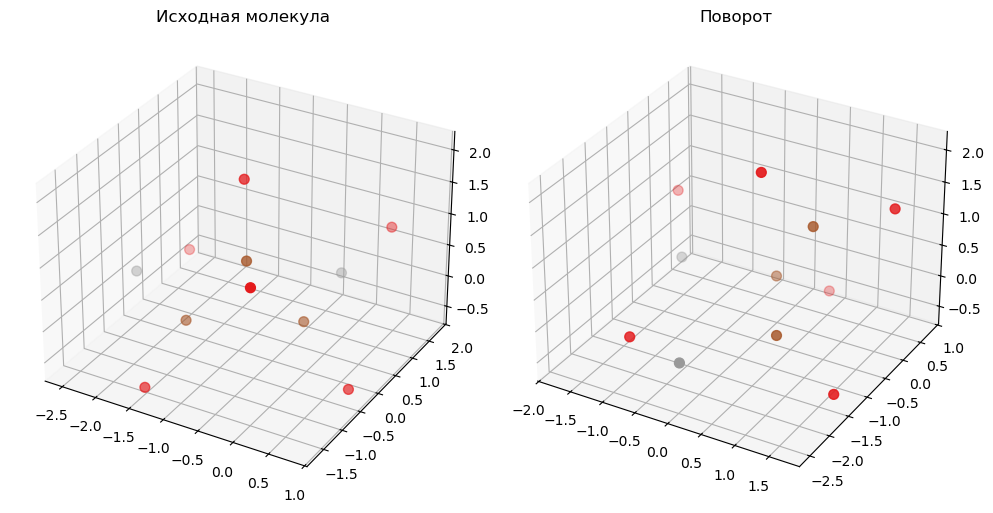

In [12]:
fig = plt.figure(figsize=(10, 5))
for i, (d, title) in enumerate([(data_orig, "Исходная молекула"), (data_rot, "Поворот")]):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    p = d.pos.cpu().numpy()
    ax.scatter(p[:,0], p[:,1], p[:,2], c=d.z.cpu(), s=50, cmap='Set1')
    ax.set_title(title)
plt.tight_layout()
plt.show()